В домашнем задании Lite вам предлагается поработать подробнее с параметрами словаря и формированием гиперпараметров нейронной сети. Создайте 9 нейросетей с различными гиперпараметрами (см. пунтк 2 и 3)

 Для этого необходимо:

  1. Воссоздать ноутбук, аналогичный ноутбуку практической части №1, загрузив при этом необходимую нам базу (код уже доступен в ноутбуке).

  2. Задать в ноутбуке следующие параметры для размера словаря, ширины окна и шага:

    - Размер словаря - от 10000 до 20000 (выбрать меньшее значение диапазона, если будет перегрузка ОЗУ и перезапуск подключения к Colaboratory)
    - Ширина окна - от 1000 до 2000
    - Шаг - от 100 до 500 (на обучение лучше влияет наименьший шаг, но это может перегрузить ОЗУ).

  3. Создать архитектуру сети и задать гиперпараметры. Можно воспользоваться шаблоном:
  
   - Добавьте модель прямого распространения **Sequential()**
   - Добавьте один или несколько полносвязных (**Dense**) слоёв
   - Добавьте слои **Dropout()** и **BatchNormalization()**
   - Добавьте выходной полносвязный слой с количеством нейронов, соответствующим количеству классов (число писателей)
  
   Напомним, что точность сети можно проверить по значению показателя 'val_accuracy' на конце каждой эпохи.
   

In [1]:
import numpy as np
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    SpatialDropout1D,
    BatchNormalization,
    Embedding,
    Flatten,
    Activation,
)

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

# Распаковка архива в папку writers
!unzip -qo writers.zip -d writers/

# Просмотр содержимого папки
!ls writers


'(Булгаков) Обучающая_5 вместе.txt'
'(Булгаков) Тестовая_2 вместе.txt'
'(Клиффорд_Саймак) Обучающая_5 вместе.txt'
'(Клиффорд_Саймак) Тестовая_2 вместе.txt'
'(Макс Фрай) Обучающая_5 вместе.txt'
'(Макс Фрай) Тестовая_2 вместе.txt'
'(О. Генри) Обучающая_50 вместе.txt'
'(О. Генри) Тестовая_20 вместе.txt'
'(Рэй Брэдберри) Обучающая_22 вместе.txt'
'(Рэй Брэдберри) Тестовая_8 вместе.txt'
'(Стругацкие) Обучающая_5 вместе.txt'
'(Стругацкие) Тестовая_2 вместе.txt'


In [3]:
# Настройка констант для загрузки данных
FILE_DIR = "writers"
SIG_TRAIN = "обучающая"
SIG_TEST = "тестовая"

In [4]:
# Загрузка датасета. Добавляются имена классов и соответствующие тексты.
# Все тексты преобразуются в строку и объединяются для каждого класса и выборки
CLASS_LIST = []
text_train = []
text_test = []

for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса и типа выборки из имени файла
    m = re.match(r"\((.+)\) (\S+)_", file_name)
    # Если выделение получилось, то файл обрабатывается
    if m:
        class_name = m[1]
        subset_name = m[2].lower()
        # Проверка типа выборки в имени файла
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатывается
        if is_train or is_test:
            # Добавление нового класса, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                # Инициализация соответствующих классу строк текста
                text_train.append("")
                text_test.append("")

            # Поиск индекса класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(
                f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.'
            )
            with open(f"{FILE_DIR}/{file_name}", "r") as f:
                # Загрузка содержимого файла в строку
                text = f.read()
            # Определение выборки, куда будет добавлено содержимое
            subset = text_train if is_train else text_test
            # Добавление текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += " " + text.replace("\n", " ")

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)


Добавление класса "О. Генри"
Добавление файла "(О. Генри) Обучающая_50 вместе.txt" в класс "О. Генри", обучающая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление класса "Клиффорд_Саймак"
Добавление файла "(Клиффорд_Саймак) Тестовая_2 вместе.txt" в класс "Клиффорд_Саймак", тестовая выборка.
Добавление класса "Булгаков"
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление класса "Стругацкие"
Добавление файла "(Стругацкие) Тестовая_2 вместе.txt" в класс "Стругацкие", тестовая выборка.
Добавление файла "(Клиффорд_Саймак) Обучающая_5 вместе.txt" в класс "Клиффорд_Саймак", обучающая выборка.
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление файла "(Булгаков) Обучающая_5 вместе.txt" в класс "Булгаков", обучающая выборка.
Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Обучающая_22 вм

In [5]:
# Прочитанные классы текстов
print(CLASS_LIST)

# Количество текстов в обучающей выборке
print(len(text_train))

# Количество символов в одном из текстов обучающей выборки
print(len(text_train[2]))


['О. Генри', 'Макс Фрай', 'Клиффорд_Саймак', 'Булгаков', 'Стругацкие', 'Рэй Брэдберри']
6
1609508


In [6]:
# Проверка загрузки: вывод начальных отрывков из каждого класса
for cls in range(CLASS_COUNT):
    print(f"Класс: {CLASS_LIST[cls]}")
    print(f"  train: {text_train[cls][:200]}")
    print(f"  test : {text_test[cls][:200]}")
    print()


Класс: О. Генри
  train:  «Лиса-на-рассвете»   Коралио нежился в полуденном зное, как томная красавица в сурово хранимом гареме. Город лежал у самого моря на полоске наносной земли. Он казался брильянтиком, вкрапленным в ярко
  test :  ﻿Багдадская птица   Без всякого сомнения, дух и гений калифа Гаруна аль-Рашида осенил маркграфа Августа-Михаила фон Паульсена Квигга.  Ресторан Квигга находится на Четвертой авеню — на улице, которую

Класс: Макс Фрай
  train:  ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне ежедневно снится какая-то дичь! – сердито сказал я Джуффину. – Сглазили они меня, что ли? А собственно, по
  test :  ﻿Слишком много кошмаров    Когда балансируешь над пропастью на узкой, скользкой от крови доске, ответ на закономерный вопрос: «Как меня сюда занесло?» – вряд ли принесёт практическую пользу. Зато пои

Класс: Клиффорд_Саймак
  train:  ﻿Всё живое...     Когда я выехал из нашего городишка и повернул на шоссе, позади оказался гр

In [7]:
# Задание параметров преобразования
PARAMS = ((10000, 1000, 100), (15000, 1500, 250), (20000, 2000, 500))

# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with
class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print("Время обработки: {:.2f} с".format(time.time() - self.t))


In [8]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)
    ]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)


In [9]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(
    model,
    x_train,
    y_train,
    x_val,
    y_val,
    optimizer="adam",
    epochs=50,
    batch_size=128,
    figsize=(20, 5),
):
    # Компиляция модели
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Вывод сводки
    model.summary()
    print("Start training...")
    # Обучение модели с заданными параметрами
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1,
    )

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("График процесса обучения модели")
    ax1.plot(
        history.history["accuracy"], label="Доля верных ответов на обучающем наборе"
    )
    ax1.plot(
        history.history["val_accuracy"],
        label="Доля верных ответов на проверочном наборе",
    )
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("Доля верных ответов")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающем наборе")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочном наборе")
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()

In [10]:
# Функция вывода результатов оценки модели на заданных данных
def eval_model(
    model, x, y_true, class_labels=[], cm_round=3, title="", figsize=(10, 10)
):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f"Нейросеть {title}: матрица ошибок нормализованная", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print("-" * 100)
    print(f"Нейросеть: {title}")

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = "ВЕРНО :-)" if cls_pred == cls else "НЕВЕРНО :-("
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print(
            "Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}".format(
                class_labels[cls],
                100.0 * cm[cls, cls_pred],
                class_labels[cls_pred],
                msg,
            )
        )

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )


In [11]:
# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    class_labels=CLASS_LIST,
    title="",
    optimizer="adam",
    epochs=50,
    batch_size=128,
    graph_size=(20, 5),
    cm_size=(10, 10),
):
    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(
        model,
        x_train,
        y_train,
        x_test,
        y_test,
        optimizer=optimizer,
        epochs=epochs,
        batch_size=batch_size,
        figsize=graph_size,
    )

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(
        model, x_test, y_test, class_labels=class_labels, title=title, figsize=cm_size
    )
    return model.evaluate(x_test, y_test)


In [12]:
# Функция для создания модели нейросети с заданным входным размером и архитектурой слоев
def build_model(size, layer_sizes):
    model = Sequential()
    model.add(Input((size,))) # Входной слой с заданным размером входных данных
    for units in layer_sizes:  # Добавляем скрытые слои согласно переданному списку размеров
        model.add(Dense(units))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(0.25))
    model.add(Dense(CLASS_COUNT, activation="softmax")) # Добавляем скрытые слои согласно переданному списку размеров
    return model

# Функция для создания и обучения моделей с разной сложностью архитектуры
def create_and_train_models(size, results, x_train, y_train, x_test, y_test):
    # Список конфигураций моделей: название и структура скрытых слоев
    configurations = [
        ("Lite", [256]),  # Легкая модель с 1 скрытым слоем на 256 нейронов
        ("Middle", [256, 128]),  # Средняя модель с 2 скрытыми слоями
        ("Hard", [256, 128, 64]),   # Сложная модель с 3 скрытыми слоями
    ]

    # Обучаем и оцениваем каждую модель из списка конфигураций
    for name, layers in configurations:
        model = build_model(size, layers) # Построение модели
        _, acc = compile_train_eval_model( # Компиляция, обучение и оценка
            model,
            x_train,
            y_train,
            x_test,
            y_test,
            class_labels=CLASS_LIST,
            title=name,
        )
        results["Название модели"].append(name)
        results["Количество слоев"].append(len(layers))
        results["Нейроны в 1 слое"].append(layers[0])
        results["Точность (val_accuracy)"].append(acc)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,562,822 (9.78 MB)

 Trainable params: 2,562,310 (9.77 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9301 - loss: 0.2130 - val_accuracy: 0.8542 - val_loss: 0.4937
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8805 - val_loss: 0.3710
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.8408e-04 - val_accuracy: 0.8862 - val_loss: 0.3383
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.2928e-04 - val_accuracy: 0.8893 - val_loss: 0.3264
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3069e-04 - val_accuracy: 0.8914 - val_loss: 0.3193
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.7320e-04 - val_accuracy: 0.8923 - val_loss: 0.3150
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3359e-04 - val_accuracy: 0.8929 - val_loss: 0.3128
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1

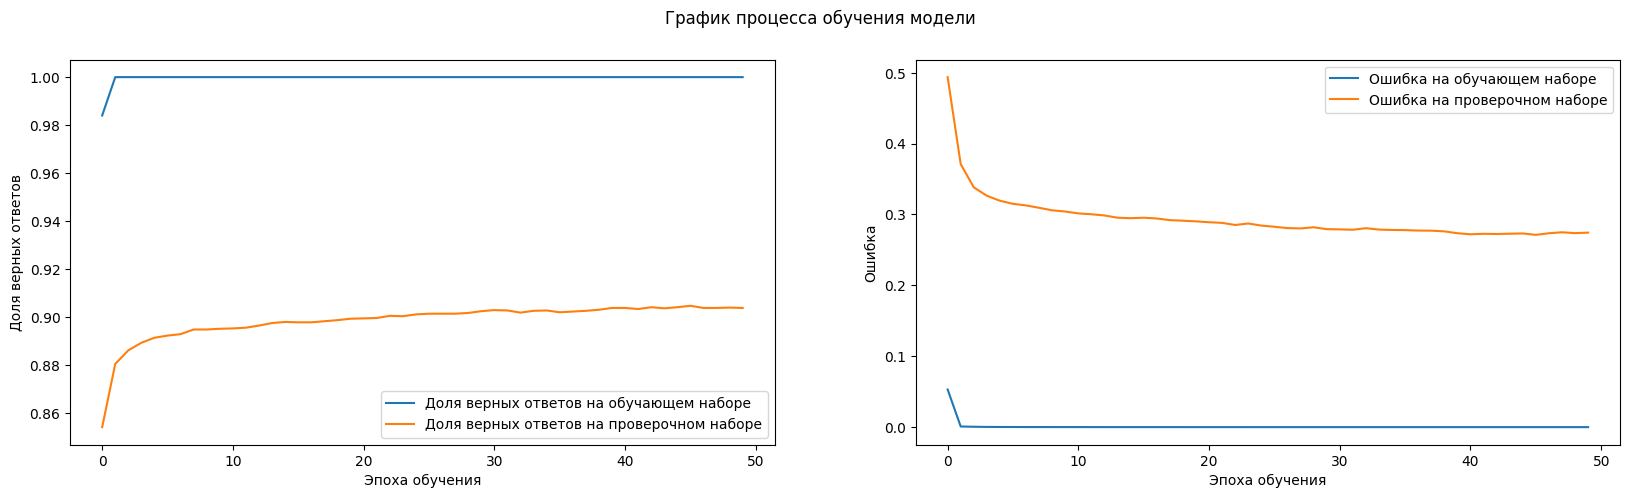

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


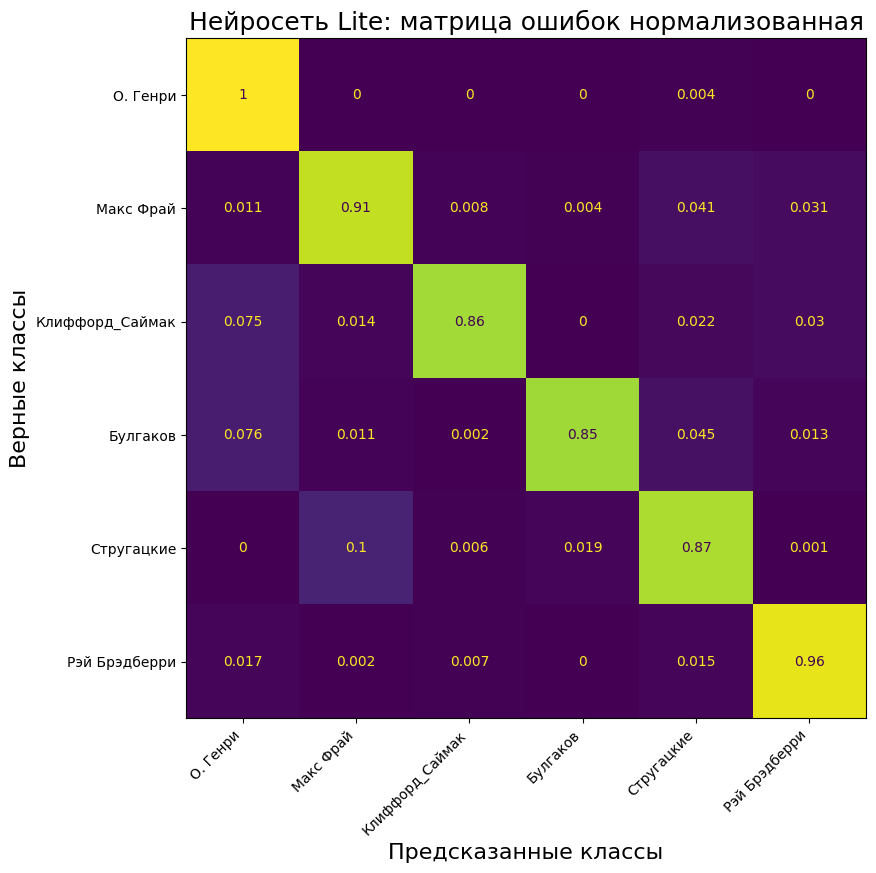

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: О. Генри             100% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             90% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       86% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              85% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            87% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         96% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  91%
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9320 - loss: 0.2084


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,595,462 (9.90 MB)

 Trainable params: 2,594,694 (9.90 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8908 - loss: 0.3552 - val_accuracy: 0.8244 - val_loss: 0.5620
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8612 - val_loss: 0.4090
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8730 - val_loss: 0.3647
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8781 - val_loss: 0.3440
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.7742e-04 - val_accuracy: 0.8781 - val_loss: 0.3379
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2805e-04 - val_accuracy: 0.8793 - val_loss: 0.3336
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.4021e-04 - val_accuracy: 0.8833 - val_loss: 0.3251
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - 

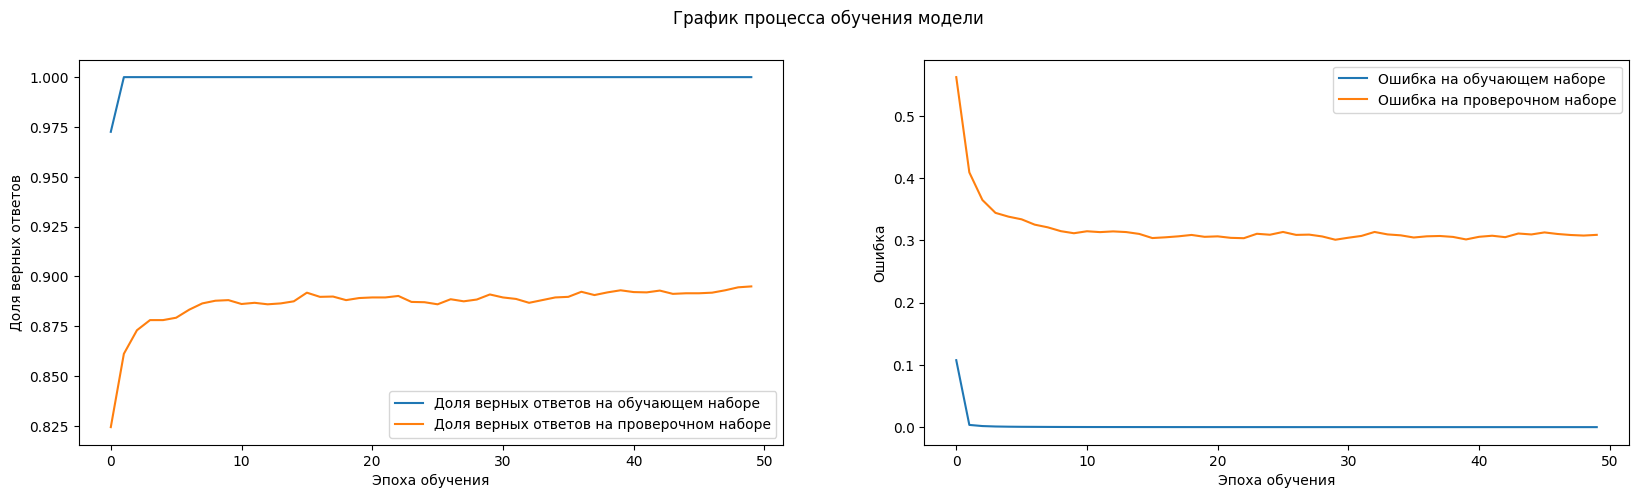

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


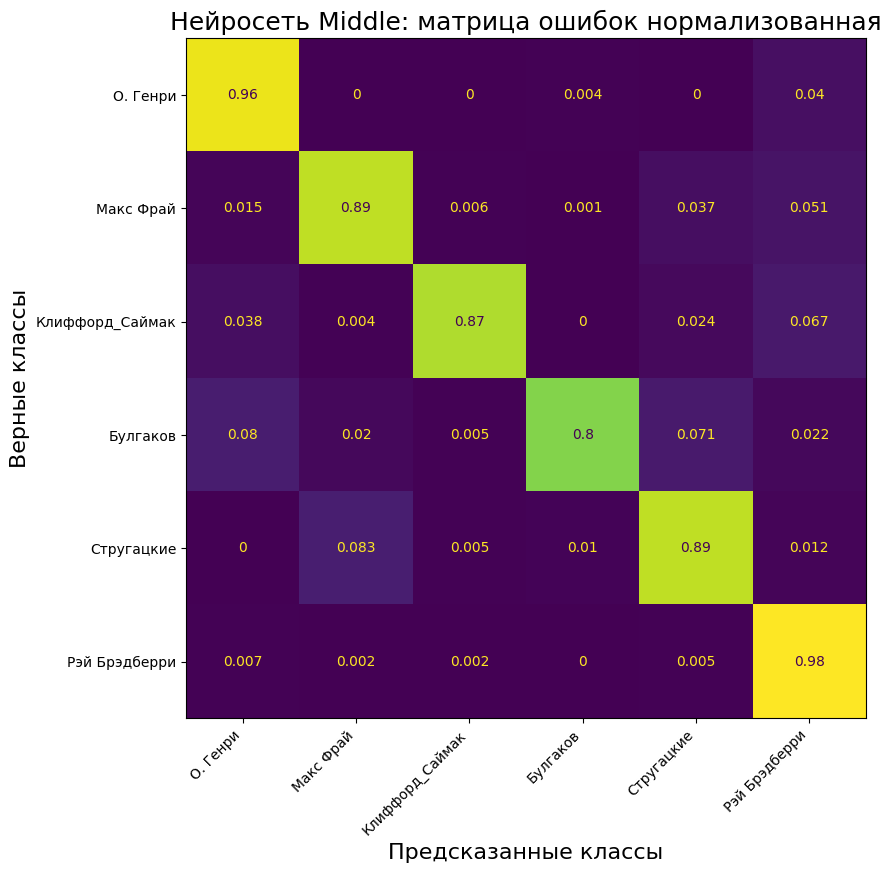

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: О. Генри              96% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             89% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       87% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              80% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         98% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  90%
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9113 - loss: 0.2553


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,603,590 (9.93 MB)

 Trainable params: 2,602,694 (9.93 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8022 - loss: 0.6203 - val_accuracy: 0.8023 - val_loss: 0.6021
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9998 - loss: 0.0195 - val_accuracy: 0.8639 - val_loss: 0.4025
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8806 - val_loss: 0.3488
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.8878 - val_loss: 0.3229
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.8877 - val_loss: 0.3208
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.8938 - val_loss: 0.3070
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8941 - val_loss: 0.3024
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.00

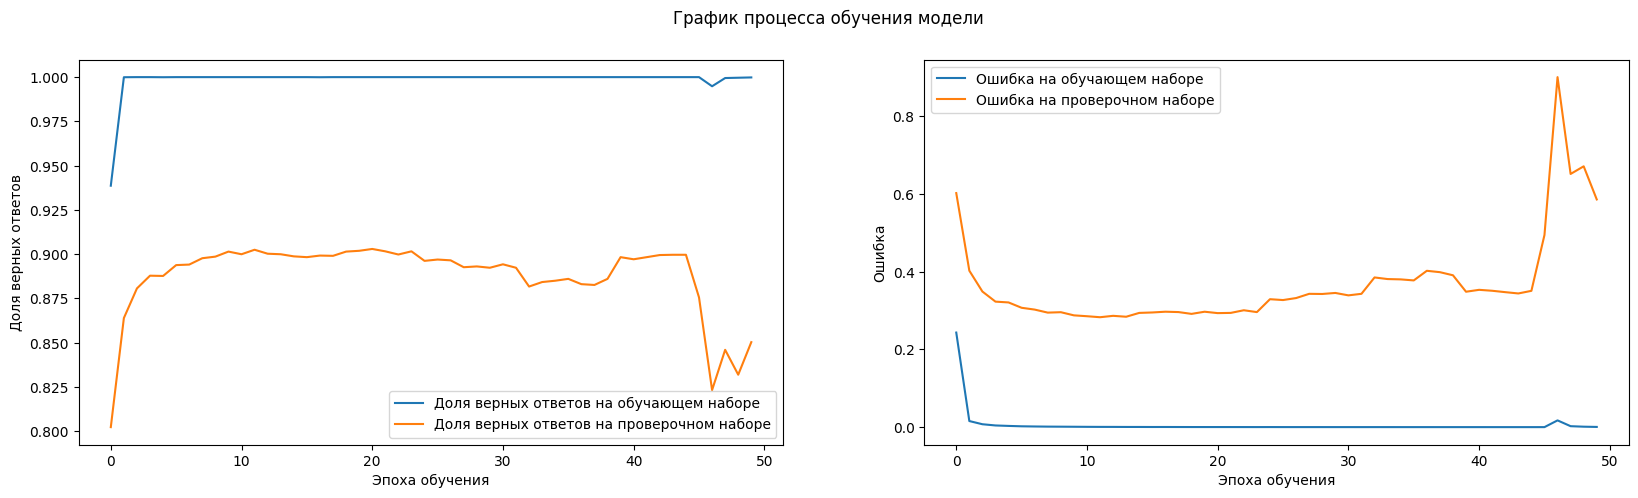

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


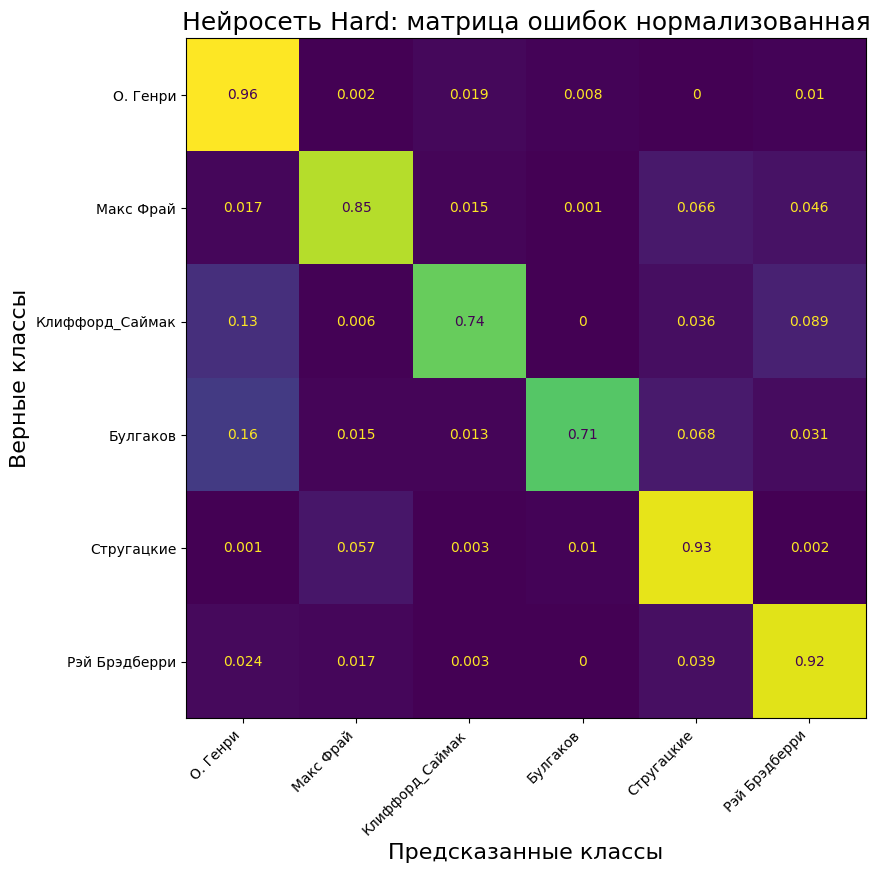

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: О. Генри              96% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             86% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       74% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              71% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            93% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         92% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  85%
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8834 - loss: 0.4578


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,842,822 (14.66 MB)

 Trainable params: 3,842,310 (14.66 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8904 - loss: 0.3230 - val_accuracy: 0.7608 - val_loss: 0.6996
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8603 - val_loss: 0.4583
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.5704e-04 - val_accuracy: 0.8949 - val_loss: 0.3585
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 6.1133e-04 - val_accuracy: 0.9148 - val_loss: 0.3087
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.5894e-04 - val_accuracy: 0.9223 - val_loss: 0.2882
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.1743e-04 - val_accuracy: 0.9245 - val_loss: 0.2752
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.8226e-04 - val_accuracy: 0.9256 - val_loss: 0.2669
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss:

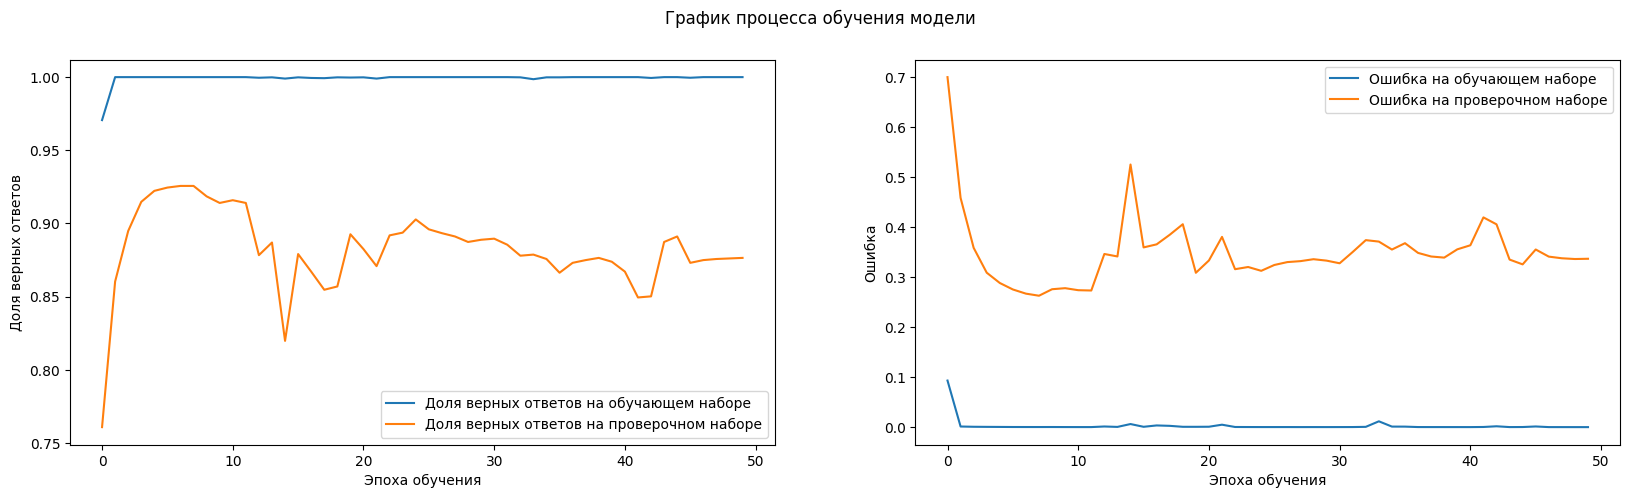

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


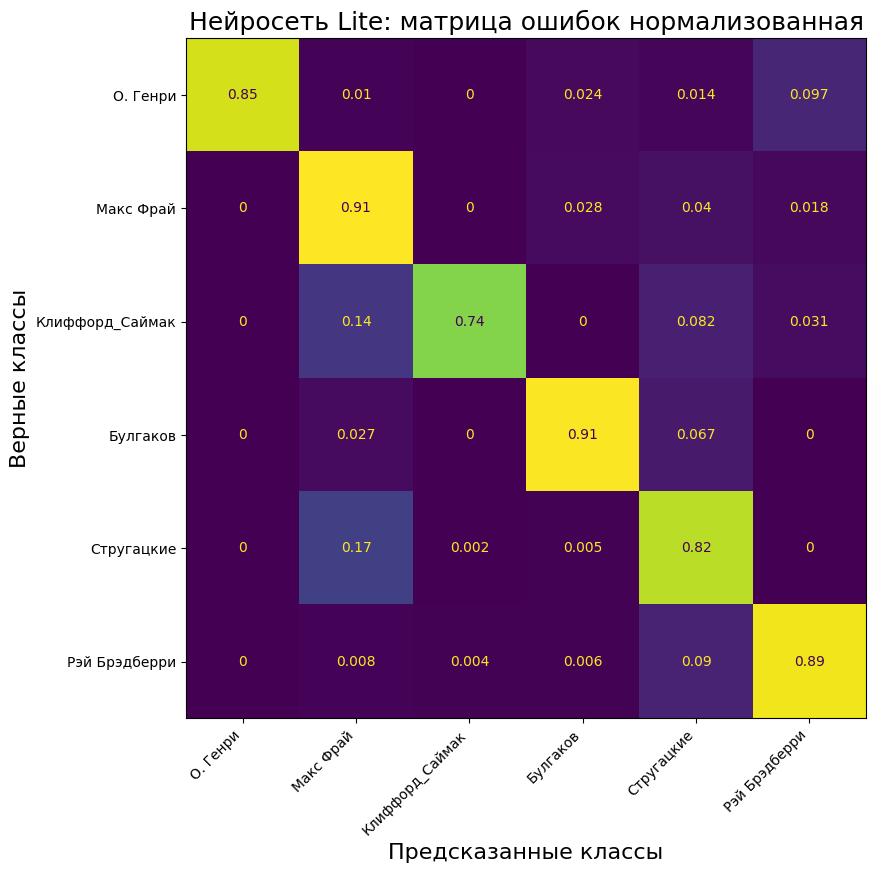

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: О. Генри              86% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             91% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       74% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              91% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            82% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         89% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  86%
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8919 - loss: 0.2994


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,875,462 (14.78 MB)

 Trainable params: 3,874,694 (14.78 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8313 - loss: 0.5173 - val_accuracy: 0.8194 - val_loss: 0.6456
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0120 - val_accuracy: 0.8584 - val_loss: 0.4839
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0062 - val_accuracy: 0.8862 - val_loss: 0.3987
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0042 - val_accuracy: 0.9148 - val_loss: 0.3203
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0033 - val_accuracy: 0.9193 - val_loss: 0.3001
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9069 - val_loss: 0.3114
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8990 - val_loss: 0.3186
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accurac

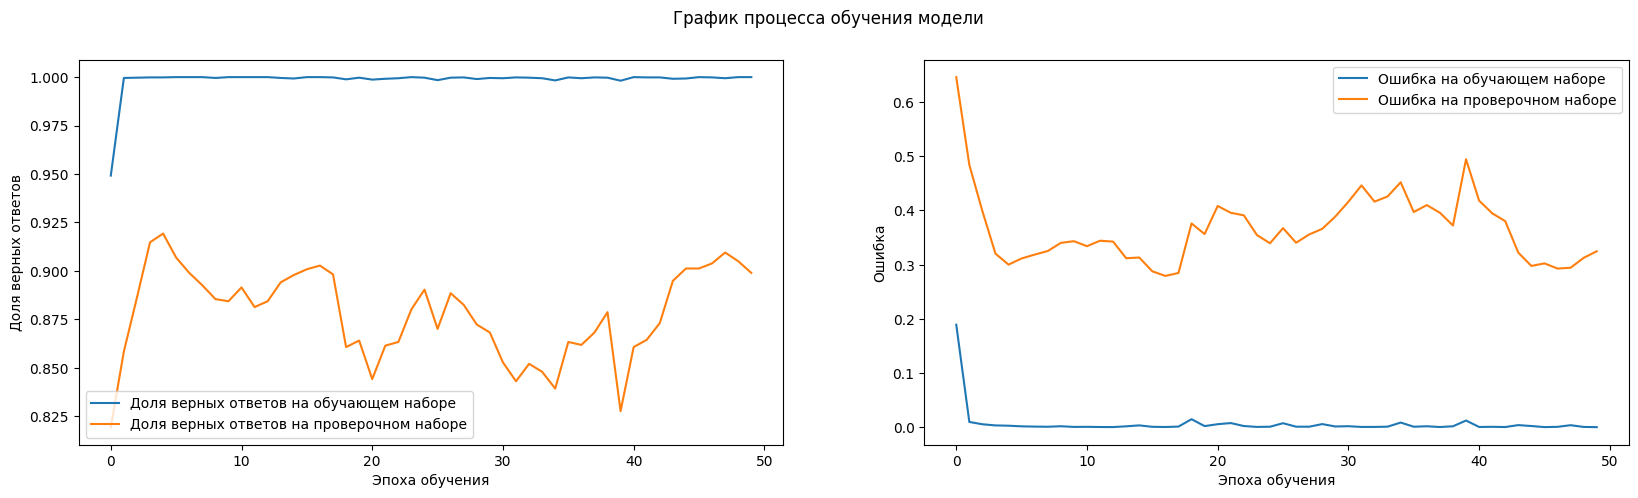

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


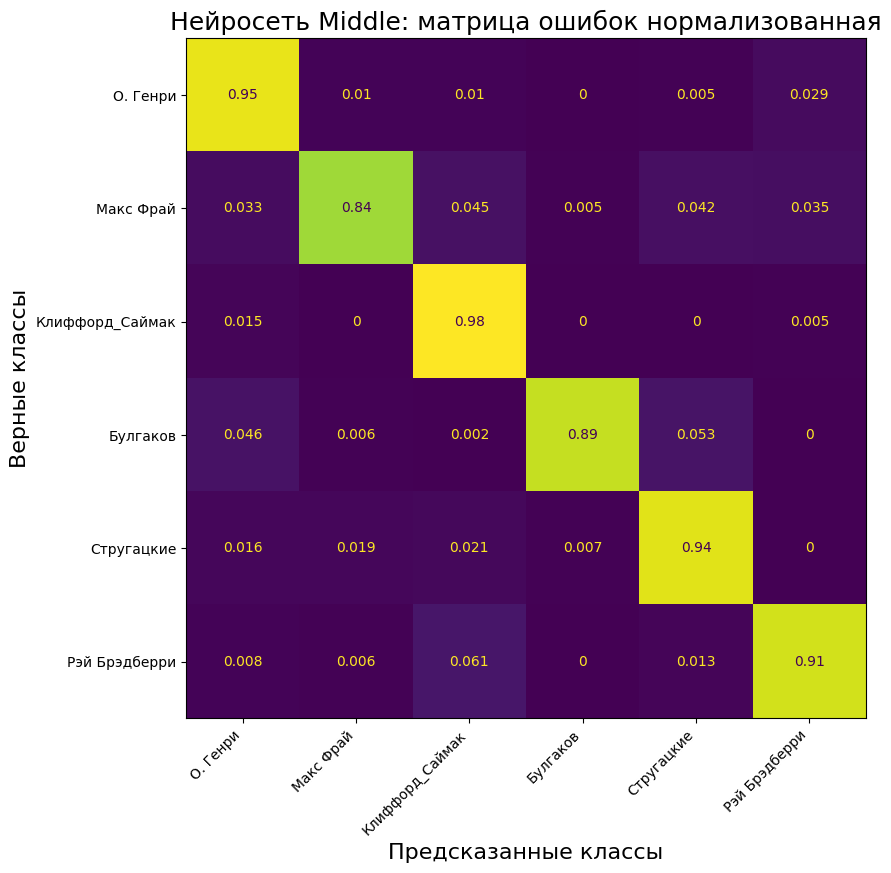

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: О. Генри              95% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             84% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       98% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              89% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            94% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         91% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  92%
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9115 - loss: 0.2839


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,883,590 (14.81 MB)

 Trainable params: 3,882,694 (14.81 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7338 - loss: 0.8282 - val_accuracy: 0.7856 - val_loss: 0.7545
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 1.0000 - loss: 0.0547 - val_accuracy: 0.8517 - val_loss: 0.5108
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0291 - val_accuracy: 0.8892 - val_loss: 0.3695
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 0.8986 - val_loss: 0.3176
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9997 - loss: 0.0127 - val_accuracy: 0.9106 - val_loss: 0.2855
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.8986 - val_loss: 0.2860
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8986 - val_loss: 0.2835
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9984 - loss: 0.0127 - val_accu

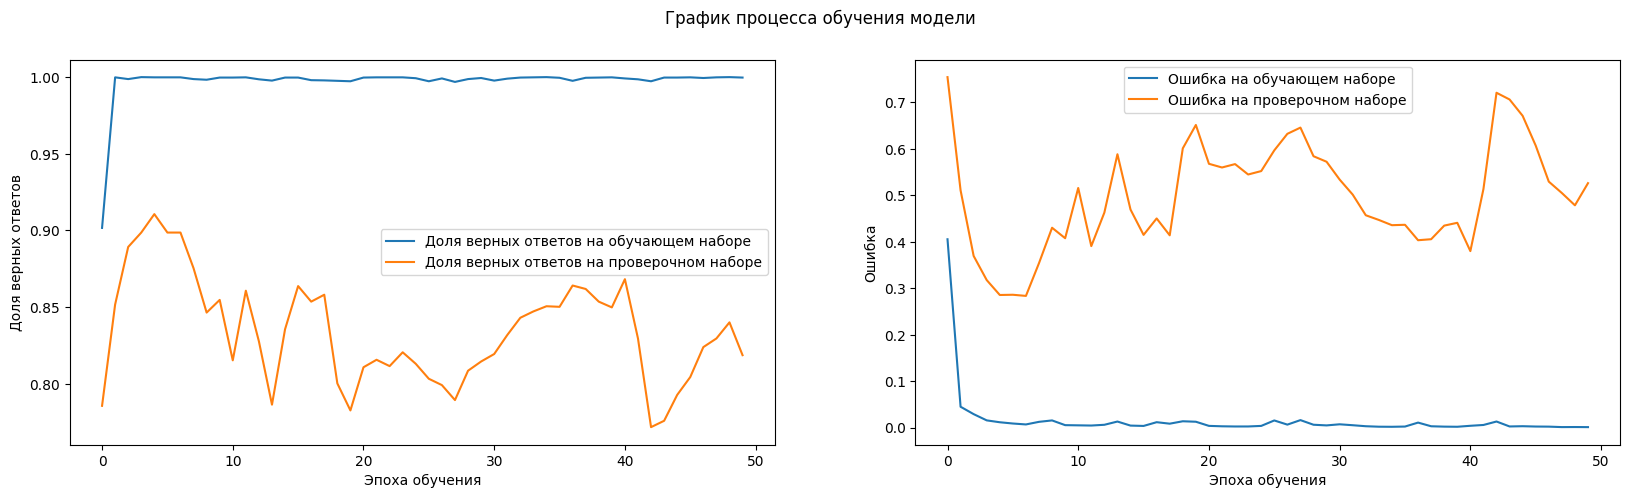

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


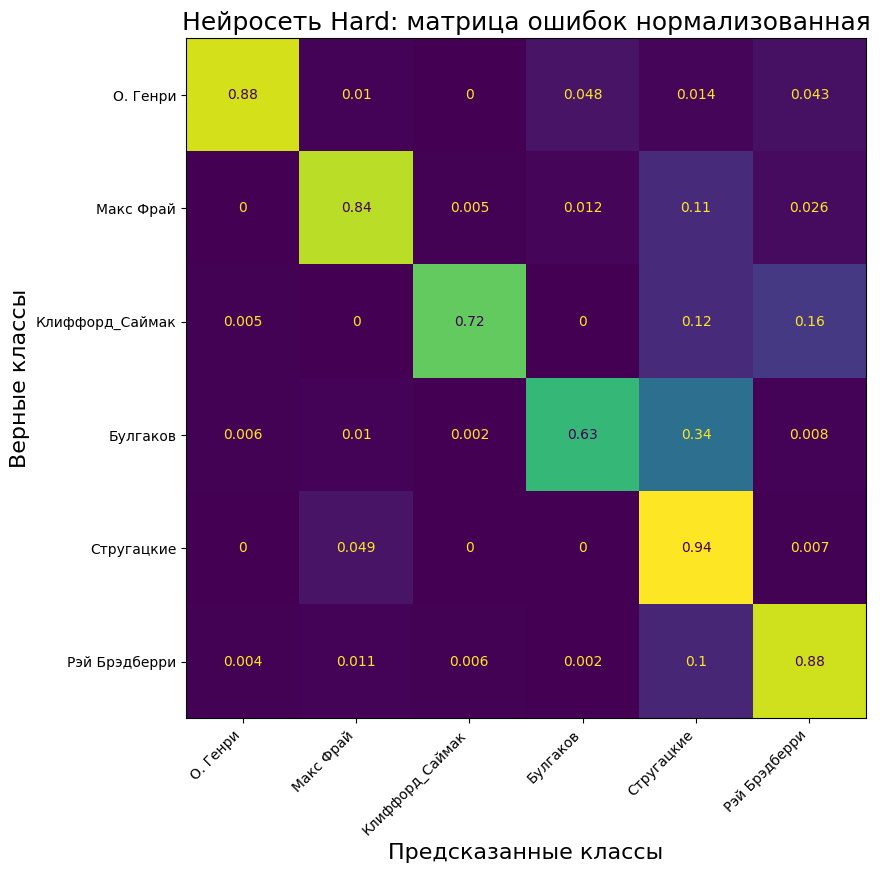

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: О. Генри              88% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             84% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       72% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              63% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            94% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри         88% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  82%
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8475 - loss: 0.4338


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,122,822 (19.54 MB)

 Trainable params: 5,122,310 (19.54 MB)

 Non-trainable params: 512 (2.00 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8486 - loss: 0.4496 - val_accuracy: 0.7236 - val_loss: 1.0582
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7628 - val_loss: 0.7456
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8276 - val_loss: 0.5336
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8705 - val_loss: 0.4032
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 8.1895e-04 - val_accuracy: 0.9066 - val_loss: 0.3294
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 6.0794e-04 - val_accuracy: 0.9232 - val_loss: 0.2860
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 5.9661e-04 - val_accuracy: 0.9337 - val_loss: 0.2614
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.9

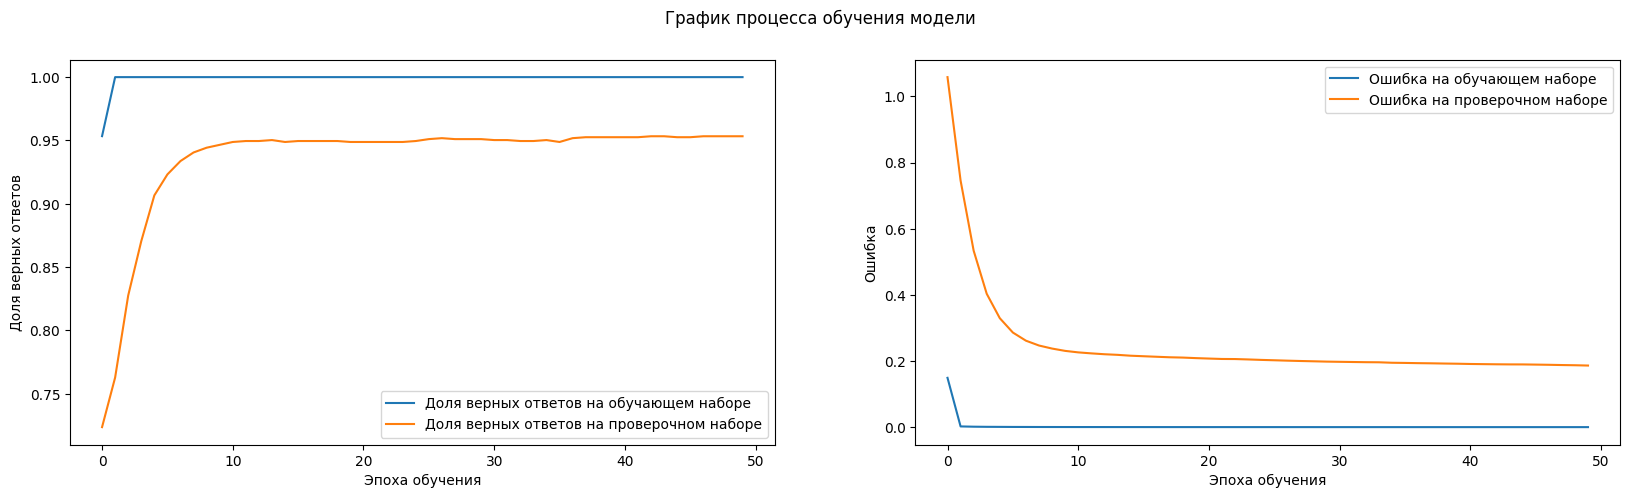

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


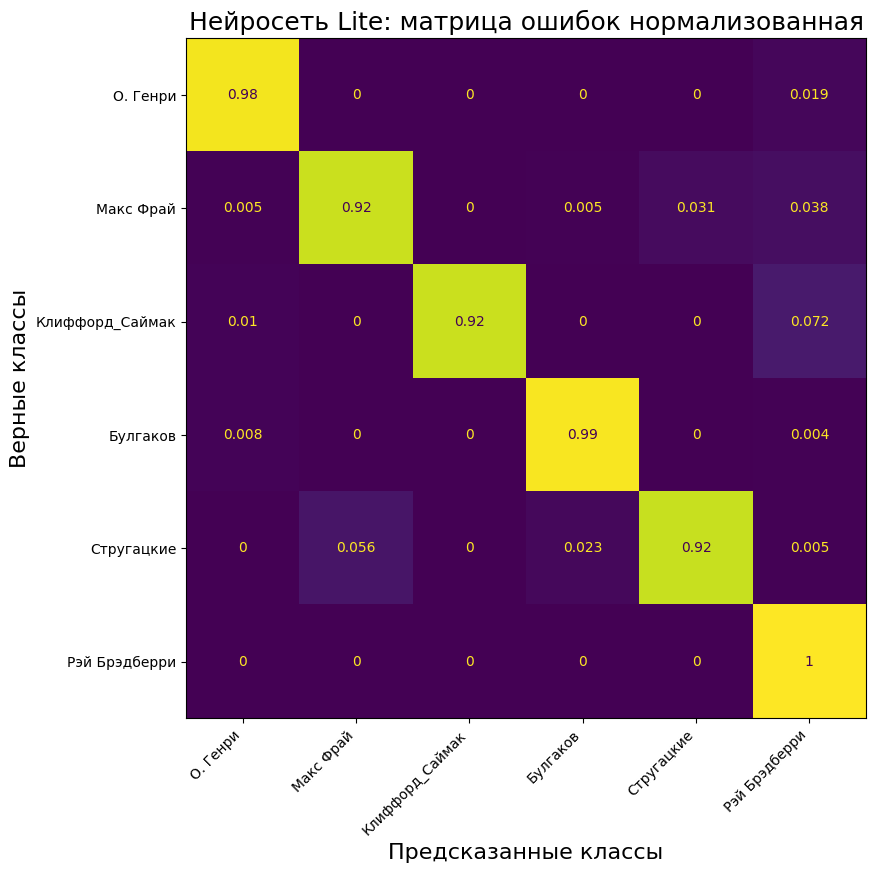

----------------------------------------------------------------------------------------------------
Нейросеть: Lite
Класс: О. Генри              98% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             92% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       92% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              99% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            92% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  95%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9563 - loss: 0.1675


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,155,462 (19.67 MB)

 Trainable params: 5,154,694 (19.66 MB)

 Non-trainable params: 768 (3.00 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7801 - loss: 0.6860 - val_accuracy: 0.7349 - val_loss: 0.7730
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.8057 - val_loss: 0.5896
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.8456 - val_loss: 0.4895
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.8660 - val_loss: 0.4208
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8931 - val_loss: 0.3739
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9051 - val_loss: 0.3434
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9104 - val_loss: 0.3187
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0022 - val_a

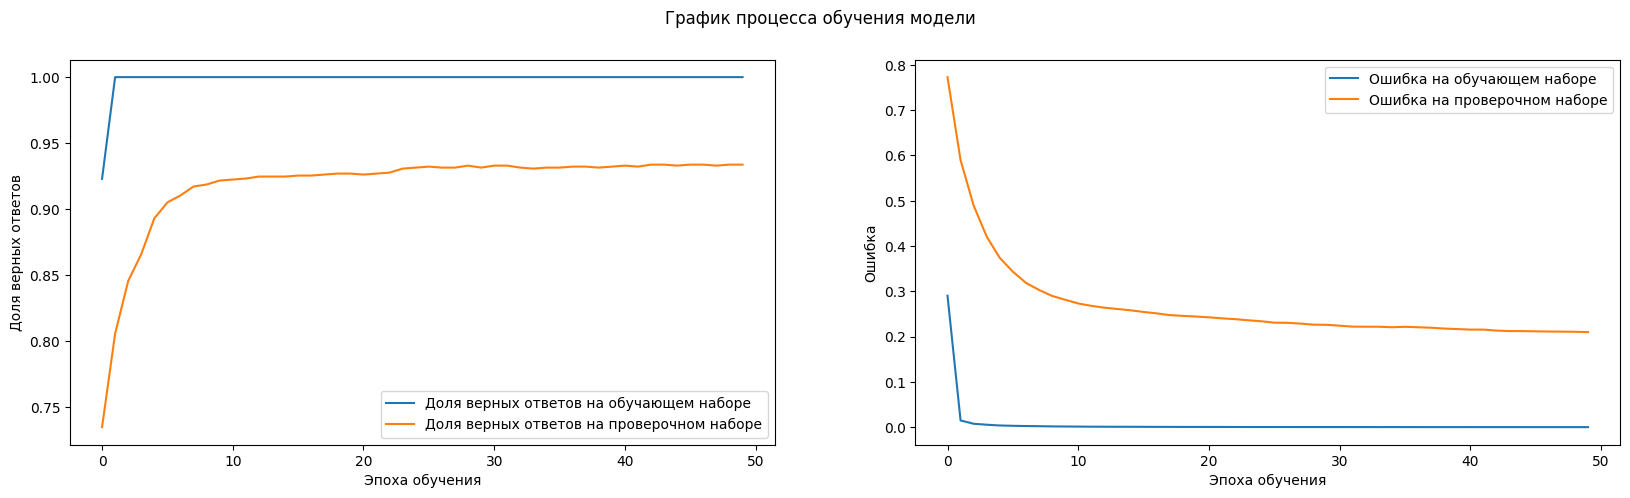

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


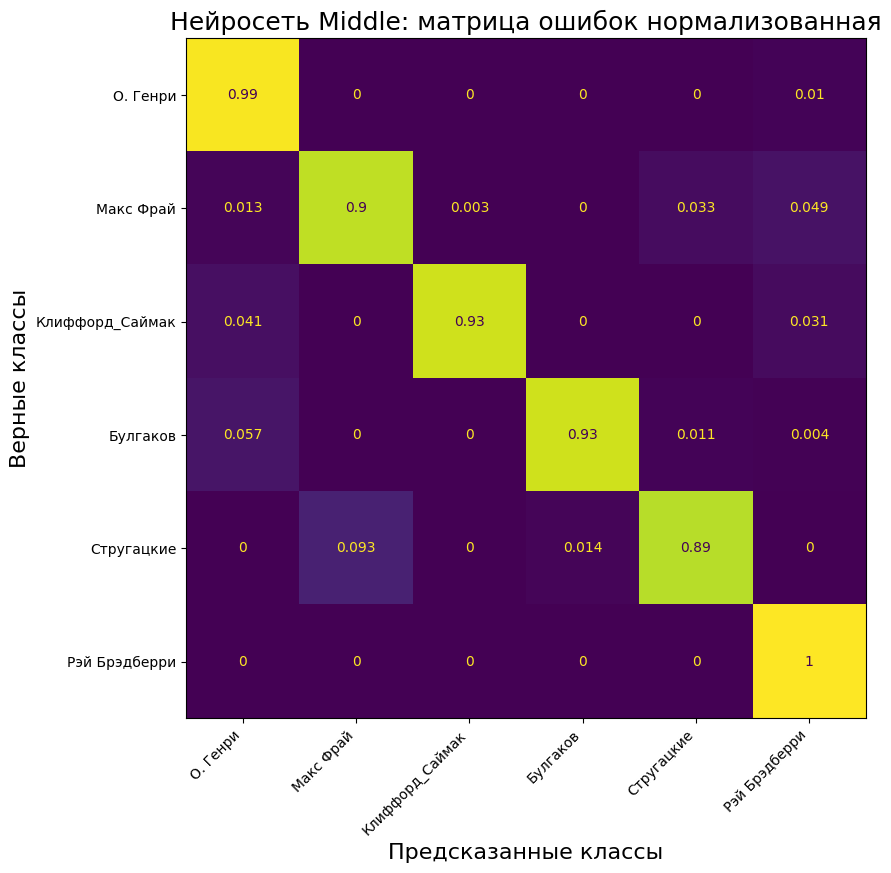

----------------------------------------------------------------------------------------------------
Нейросеть: Middle
Класс: О. Генри              99% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             90% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       93% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              93% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            89% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  94%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9432 - loss: 0.1733


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,163,590 (19.70 MB)

 Trainable params: 5,162,694 (19.69 MB)

 Non-trainable params: 896 (3.50 KB)

Start training...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.6700 - loss: 0.9989 - val_accuracy: 0.6958 - val_loss: 1.0626
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9963 - loss: 0.1419 - val_accuracy: 0.8328 - val_loss: 0.6306
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0538 - val_accuracy: 0.8486 - val_loss: 0.5116
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9989 - loss: 0.0307 - val_accuracy: 0.8539 - val_loss: 0.4558
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.8637 - val_loss: 0.4163
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 0.8712 - val_loss: 0.3968
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0135 - val_accuracy: 0.8705 - val_loss: 0.3800
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0102 - val_a

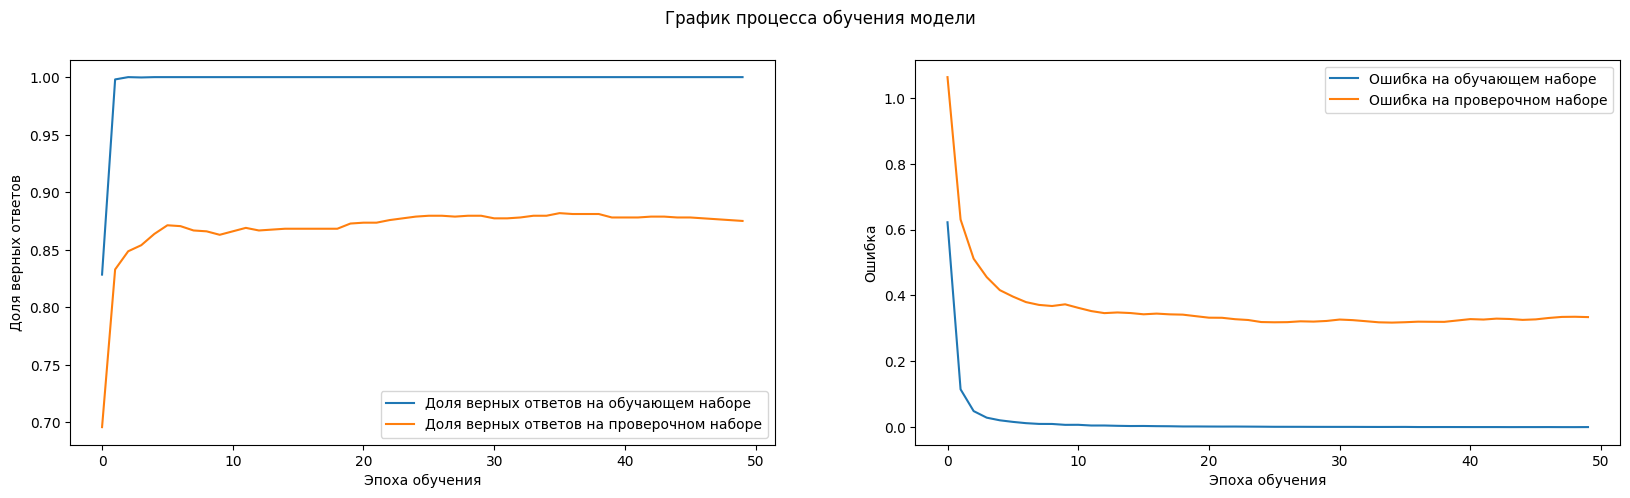

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


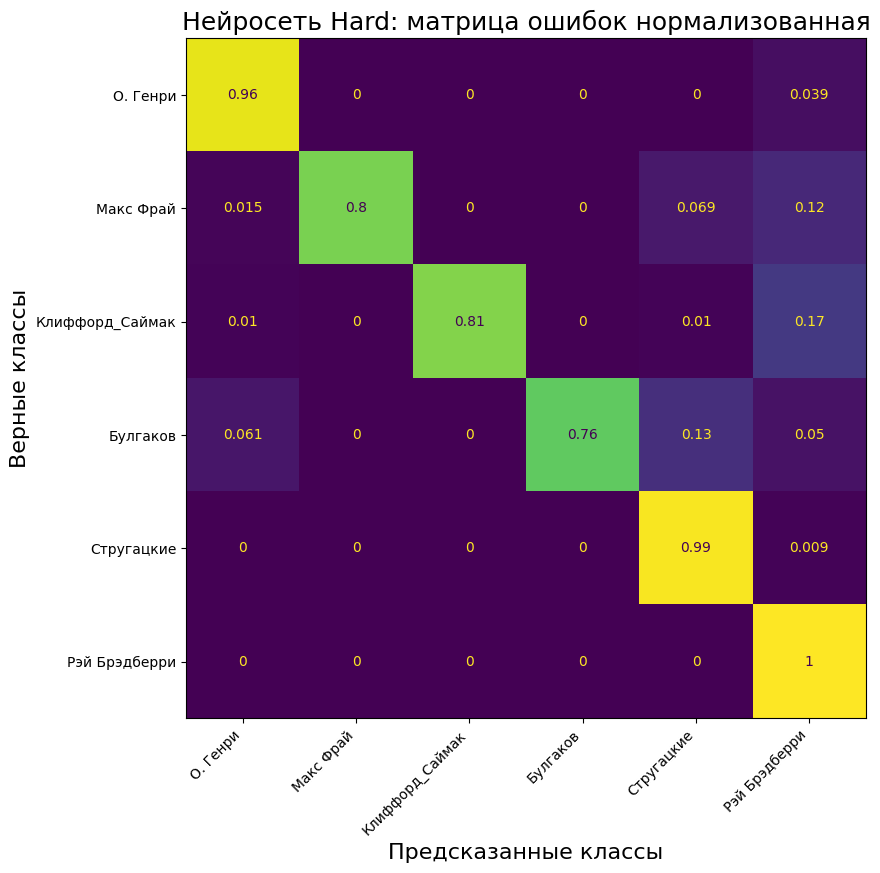

----------------------------------------------------------------------------------------------------
Нейросеть: Hard
Класс: О. Генри              96% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Макс Фрай             80% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: Клиффорд_Саймак       81% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)
Класс: Булгаков              76% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            99% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Рэй Брэдберри        100% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)

Средняя точность распознавания:  89%
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8780 - loss: 0.3298
Время обработки: 511.28 с


In [13]:
with timex():
    # Инициализация словаря для хранения результатов экспериментов
    results = {
        "Размер словаря": [],
        "Ширина окна": [],
        "Шаг окна": [],
        "Название модели": [],
        "Количество слоев": [],
        "Нейроны в 1 слое": [],
        "Точность (val_accuracy)": [],
    }
    # Проход по списку параметров (размер словаря, ширина окна, шаг окна)
    for vocab_size, win_size, win_hope in PARAMS:
        results["Размер словаря"].extend([vocab_size] * 3)
        results["Ширина окна"].extend([win_size] * 3)
        results["Шаг окна"].extend([win_hope] * 3)

        # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
        tokenizer = Tokenizer(
            num_words=vocab_size,
            filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
            lower=True,
            split=" ",
            oov_token="неизвестное_слово",
            char_level=False,
        )

        # Построение частотного словаря по обучающим текстам
        tokenizer.fit_on_texts(text_train)
        seq_train = tokenizer.texts_to_sequences(text_train)
        seq_test = tokenizer.texts_to_sequences(text_test)
        # Формирование обучающей выборки
        x_train, y_train = vectorize_sequence(seq_train, win_size, win_hope)
        # Формирование тестовой выборки
        x_test, y_test = vectorize_sequence(seq_test, win_size, win_hope)
        x_train = tokenizer.sequences_to_matrix(x_train.tolist()).astype("float16")
        x_test = tokenizer.sequences_to_matrix(x_test.tolist()).astype("float16")
        create_and_train_models(vocab_size, results, x_train, y_train, x_test, y_test)


In [16]:
import pandas as pd

df = pd.DataFrame(results)
df

,Размер словаря,Ширина окна,Шаг окна,Название модели,Количество слоев,Нейроны в 1 слое,Точность (val_accuracy)
0,10000,1000,100,Lite,1,256,0.903829
1,10000,1000,100,Middle,2,256,0.895005
2,10000,1000,100,Hard,3,256,0.850284
3,15000,1500,250,Lite,1,256,0.876455
4,15000,1500,250,Middle,2,256,0.898986
5,15000,1500,250,Hard,3,256,0.818626
6,20000,2000,500,Lite,1,256,0.953313
7,20000,2000,500,Middle,2,256,0.933735
8,20000,2000,500,Hard,3,256,0.875000
